In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
from timeit import default_timer
import numba
from numba import jit, cuda, vectorize, guvectorize
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8

# Esercizi

1. Scrivi una funzione utilizzando il decoratore @vectorize che, dati due vettori x,y calcoli il vettore z definito come
$$ z[i] = x[i]^2 \cos(y[i]). $$

2. Fai un confronto con Numpy e con la stessa funzione scritta in puro Python. Cosa puoi dire delle tempistiche? Qual è lo speed-up ottenuto rispetto a queste due implementazioni? Come cambiano le prestazioni se non tieni conto dei trasferimenti in memoria?

3. Calcola lo speed-up prendendo $n = [2^{10}, 2^{11}, \dots, 2^{19}]$ e fai un plot. Cosa puoi notare da questo grafico?
   

### 1.

In [38]:
# Versione CPU
@numba.vectorize(['float32(float32, float32)',
                  'float64(float64, float64)'], target='cpu')
def sqcos_cpu(x, y):
    return x**2 * math.cos(y)

# Versione CUDA
@numba.vectorize(['float32(float32, float32)',
                     'float64(float64, float64)'], target='cuda')
def sqcos_cuda(x, y):
    return x**2 * math.cos(y)

# Versione CUDA con gestione di memoria
def sqcos_puretime(dx, dy, dz):
    dz = sqcos_cuda(dx, dy)
    cuda.synchronize()   # assicura che il calcolo sia concluso
    return dz

### 2.

In [39]:
# Generazione dei dati
n = 1000000
x = np.linspace(10, 10, n)
y = np.linspace(0, 2*np.pi, n)

dz = cuda.device_array_like(x) # oppure numba.device_array((n,))
dx = cuda.to_device(x)
dy = cuda.to_device(y)

In [40]:
# Versione Numpy
def sqcos_np(x,y):
  return x**2 * np.cos(y)

# Versione Python
def sqcos_py(x,y):
  a = list(x)
  b = list(y)
  l = []
  for i in range(len(a)):
    tmp = a[i]**2 * math.cos(b[i])
    l += [tmp]
  return np.array(l)


# Verifica del risultato
np_ans = sqcos_np(x, y)
py_ans = sqcos_py(x, y)
cpu_ans = sqcos_cpu(x, y)
cuda_ans = sqcos_cuda(x, y)
cuda_puret_ans = sqcos_puretime(dx, dy, dz)

print("Python Version e' corretto: ", np.allclose(py_ans, np_ans))
print("CPU vectorize e' corretto: ", np.allclose(cpu_ans, np_ans))
print("GPU vectorize e' corretto: ", np.allclose(cuda_ans, np_ans))
print("GPU vectorize (opt memo) e' corretto: ", np.allclose(cuda_puret_ans, np_ans))
print()


# Speed-up
t_i = default_timer()
sqcos_np(x, y)
t_f = default_timer()
np_time = t_f -t_i

t_i = default_timer()
sqcos_py(x, y)
t_f = default_timer()
py_time = t_f -t_i

t_i = default_timer()
sqcos_cpu(x, y)
t_f = default_timer()
cpu_time = t_f -t_i

t_i = default_timer()
sqcos_cuda(x, y)
t_f = default_timer()
cuda_time = t_f -t_i

t_i = default_timer()
sqcos_puretime(dx, dy, dz)
t_f = default_timer()
cuda_puretime = t_f -t_i

print('speed-up di CPU vectorize vs Numpy = ', np_time/cpu_time )
print('speed-up di GPU vectorize vs Numpy = ', np_time/cuda_time )
print('speed-up di GPU vectorize (opt memo) vs Numpy = ', np_time/cuda_puretime )
print()
print('speed-up di CPU vectorize vs Python = ', py_time/cpu_time )
print('speed-up di GPU vectorize vs Python = ', py_time/cuda_time )
print('speed-up di GPU vectorize (opt memo) vs Python = ', py_time/cuda_puretime )


Python Version e' corretto:  True
CPU vectorize e' corretto:  True
GPU vectorize e' corretto:  True
GPU vectorize (opt memo) e' corretto:  True

speed-up di CPU vectorize vs Numpy =  0.29194090848202486
speed-up di GPU vectorize vs Numpy =  1.6628242662972104
speed-up di GPU vectorize (opt memo) vs Numpy =  2.5795261725982135

speed-up di CPU vectorize vs Python =  15.790648426748158
speed-up di GPU vectorize vs Python =  89.93968512700364
speed-up di GPU vectorize (opt memo) vs Python =  139.5227243447508


### 3.

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to l

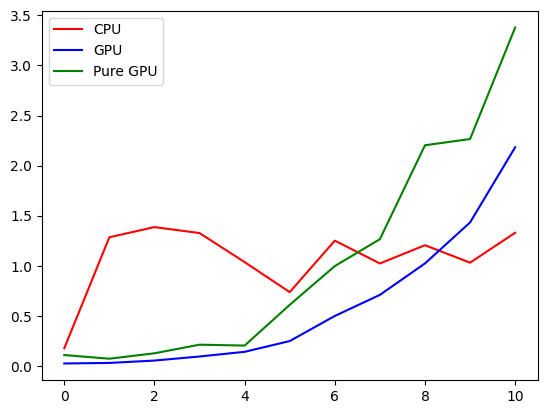

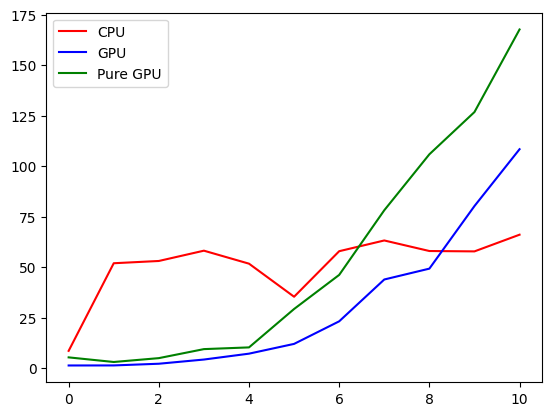

In [41]:
iterations = 11

CPUspeedupNp = np.zeros(iterations)
GPUspeedupNp = np.zeros(iterations)
PureGPUspeedupNp = np.zeros(iterations)

CPUspeedupPy = np.zeros(iterations)
GPUspeedupPy = np.zeros(iterations)
PureGPUspeedupPy = np.zeros(iterations)

for i in range(iterations):
  n = 2 ** (10+i)

  # Generazione dei dati
  x = np.linspace(10, 10, n)
  y = np.linspace(0, 2*np.pi, n)
  dz = cuda.device_array_like(x) # oppure numba.device_array((n,))
  dx = cuda.to_device(x)
  dy = cuda.to_device(y)

  # Speed-up
  t_i = default_timer()
  sqcos_np(x, y)
  t_f = default_timer()
  np_time = t_f -t_i

  t_i = default_timer()
  sqcos_py(x, y)
  t_f = default_timer()
  py_time = t_f -t_i

  t_i = default_timer()
  sqcos_cpu(x, y)
  t_f = default_timer()
  cpu_time = t_f -t_i

  t_i = default_timer()
  sqcos_cuda(x, y)
  t_f = default_timer()
  cuda_time = t_f -t_i

  t_i = default_timer()
  sqcos_puretime(dx, dy, dz)
  t_f = default_timer()
  cuda_puretime = t_f -t_i


  CPUspeedupNp[i] = np_time/cpu_time
  GPUspeedupNp[i] = np_time/cuda_time
  PureGPUspeedupNp[i] = np_time/cuda_puretime

  CPUspeedupPy[i] = py_time/cpu_time
  GPUspeedupPy[i] = py_time/cuda_time
  PureGPUspeedupPy[i] = py_time/cuda_puretime


plt.figure(1)
plt.plot(CPUspeedupNp,'r',label='CPU')
plt.plot(GPUspeedupNp,'b',label='GPU')
plt.plot(PureGPUspeedupNp,'g',label='Pure GPU')
plt.legend()

plt.figure(2)
plt.plot(CPUspeedupPy,'r',label='CPU')
plt.plot(GPUspeedupPy,'b',label='GPU')
plt.plot(PureGPUspeedupPy,'g',label='Pure GPU')
plt.legend()